In [ ]:
import numpy as np 
from cobra.io import read_sbml_model
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
from cobra import Reaction, Metabolite
from cameo.strain_design.heuristic.evolutionary_based import OptGene
from cameo.strain_design.deterministic.linear_programming import OptKnock

# path for google drive
auto = read_sbml_model('iCre1355_auto.xml')

# Flux scanning based on enforced objective flux

In following part we aim to identify gene amplification targets, therefore we used Flux scanning based on enforced objective flux. This method allows to identifiy fluxes, which increase when the hydrogen production is enforced to be a specific value. In the folllowing step the hyrdogen production will be elevated stepwise and it will be determined which fluxes either decrease or increase significantelly.

In [187]:
fseof = FSEOF(auto)
result = fseof.run(target=auto.reactions.EX_h2_e)
df= result.data_frame

In [188]:
# creating a dataframe with all changing fluxes
# sorting the dataframe
df= df.sort_values([1], ascending = False)

# removing genes from dataframe 
removed_zero = (df != 0.000000).all(axis=1)
df = df.loc[removed_zero]

In [189]:
df.head(10)

,1,2,3,4,5,6,7,8,9,10
PRISM_design_growth,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
ATPSm,41.202148,42.151699,43.156356,44.161013,44.769653,44.796339,44.549607,44.147909,44.752407,46.083245
ASPAT,36.993056,38.003497,39.024019,40.044542,41.344747,42.882579,43.662655,44.133501,44.663579,46.613638
PSIred,29.344896,29.344896,29.344896,29.344896,29.344896,29.344896,29.344896,29.344896,29.344896,29.344896
PYK,28.970415,30.034075,31.198411,32.362748,32.706600,33.026784,33.256147,33.287095,33.995611,35.381453
PYRth,28.970415,30.034075,31.198411,32.362748,32.706600,32.675334,32.774783,32.709435,33.632426,35.381453
MALOAAtm,28.563587,29.060978,29.511407,29.961837,31.406555,33.049658,34.673899,35.197673,35.865146,37.227976
HCO3Ehi,27.434967,28.014208,28.718177,29.422146,30.170408,31.189021,31.211262,31.131149,31.095004,31.796844
HCO3_h_thi,27.434967,28.014208,28.718177,29.422146,30.170408,31.189021,31.211262,31.131149,31.095004,31.796844
CBFC,25.533734,25.533734,25.533734,25.533734,25.533734,25.533734,25.533734,25.533734,25.533734,25.533734


Changing Fluxes under increasing Hydrogen production.

Text(0.5, 1.0, 'Flux scanning based on Enforced Objective Flux - EX_h2_e')

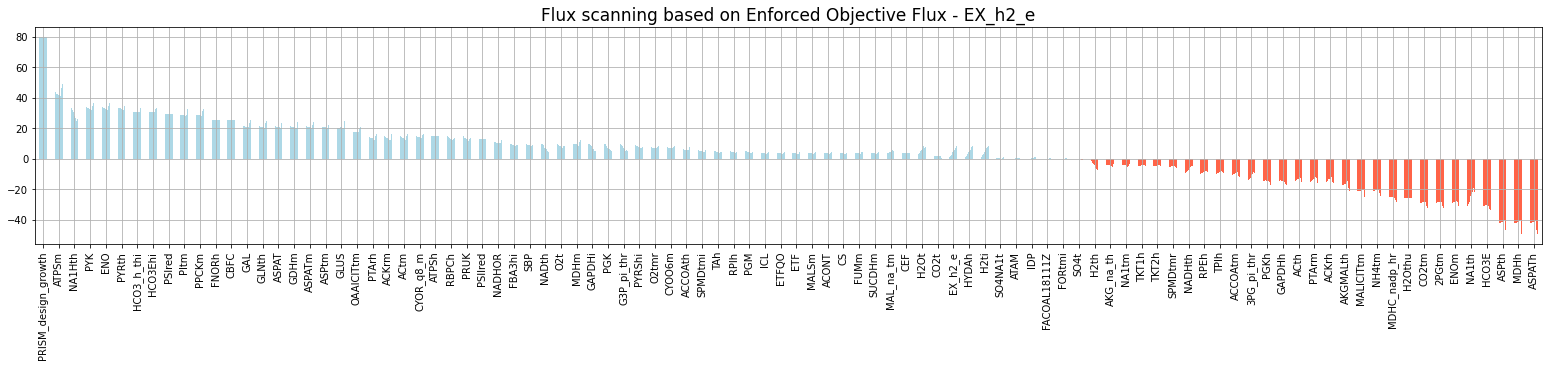

In [117]:
#@title Flux scanning based on Enforced Objective Flux - EX_h2_e
# color bars according to value
def bar_color(df,color1,color2):
    return np.where(df.values>0,color1,color2).T

fig = df.plot(legend=None, kind='bar', color=bar_color(df,'lightblue','tomato'),figsize=(27, 4), grid =True);
fig.set_title('Flux scanning based on Enforced Objective Flux - EX_h2_e', size=17)

Since there lot of changing reactions, we want to estimate which fluxes change over 50% (between 1 and 10).

In [190]:
df['rel_range'] = df.max(axis=1) /df.min(axis=1)

In [191]:
# calculating the relative change of fluxes 
df['rel_change'] = df[10]/df[1] 

In [192]:
# identifying reactions where the flux increases more than 0%
tr_df = df.loc[df['rel_change'] > 1.5]

In [193]:
tr_df

,1,2,3,4,5,6,7,8,9,10,rel_range,rel_change
MALAKGtm,13.736748,13.595349,13.537787,13.480226,15.716745,18.458926,20.607532,20.677122,21.319329,22.362273,1.658895,1.627916
H2Ot,3.339028,3.706650,4.033440,4.360231,5.007666,5.638963,6.017422,5.962386,6.670968,8.376730,2.508733,2.508733
EX_h2_e,0.837055,1.674110,2.511165,3.348220,4.185275,5.022330,5.859386,6.696441,7.533496,8.370551,10.000000,10.000000
H2ti,0.837055,1.674110,2.511165,3.348220,4.185275,5.022330,5.859386,6.696441,7.533496,8.370551,10.000001,10.000001
HYDAh,0.837055,1.673619,2.509735,3.345852,4.185275,5.004853,5.796722,6.645729,7.472965,8.370551,10.000001,10.000001
ATAM,0.614536,0.592447,0.572154,0.551861,0.682693,0.787667,0.969988,0.943359,1.177488,1.840184,3.334506,2.994428
IDP,0.614536,0.594883,0.579244,0.563604,0.682693,0.787667,0.980084,0.949466,1.177724,1.840184,3.265030,2.994428
NOS1,0.409690,0.393722,0.377821,0.361920,0.332600,0.467845,0.594009,0.703016,0.701439,0.623577,2.113698,1.522070
SERNA1th,0.365784,0.272579,0.157132,0.041684,0.105024,0.265725,0.178019,0.182568,0.133031,0.608303,14.593201,1.663012
NOS2,0.204845,0.196861,0.188911,0.180960,0.166300,0.233922,0.297005,0.351508,0.350720,0.311788,2.113698,1.522068


Text(0.5, 1.0, 'Reaction with a change in Flux over 50%')

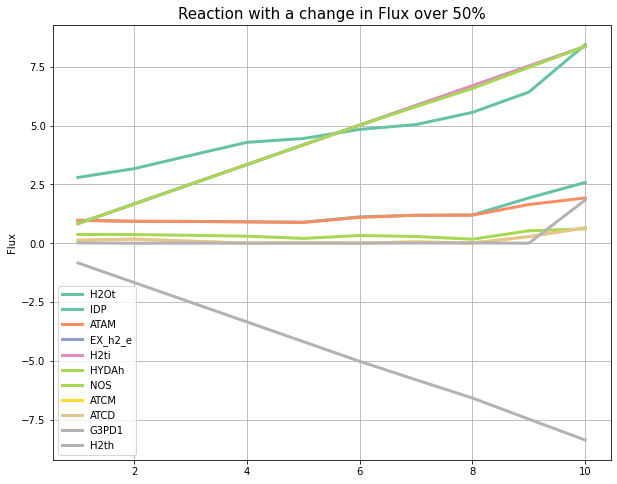

In [155]:
tr_df = tr_df.drop(['rel_change','rel_range'], axis=1)
fig = tr_df.T.plot(cmap="Set2",figsize=(10, 8), grid =True, linewidth=3);
fig.set_ylabel('Flux')
fig.set_title('Reaction with a change in Flux over 50%', size=15)

Additonally we want to know whether specific reactions vary over the stepwise increasing hydrogen production. 

In [156]:
varydf= df.loc[((df['rel_range']-df['rel_change']) <= -1) | ((df['rel_range']-df['rel_change']) >= 1)]

Text(0.5, 1.0, 'Varying fluxes under Hydrogenproduction')

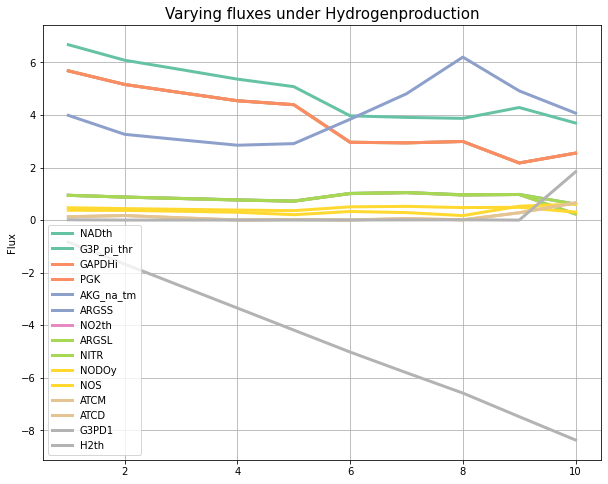

In [157]:
varydf = varydf.drop(['rel_change','rel_range'], axis=1)
fig = varydf.T.plot(cmap="Set2",figsize=(10, 8), grid =True, linewidth=3);
fig.set_ylabel('Flux')
fig.set_title('Varying fluxes under Hydrogenproduction', size=15)

## Dict of Potential Target genes

In [158]:
# for overexpression only reactions with increasing fluxes 
tr_df = tr_df.loc[tr_df[10] > 0]
arr= tr_df.index.values
# list of reactions
reactions= list(arr)

In [159]:
# creating dict with reaction names and genes
target_genes=dict()
for elem in reactions:
  target_genes[auto.reactions.get_by_id(elem).name]= auto.reactions.get_by_id(elem).gene_reaction_rule

In [160]:
target_genes

{'(FeFe)-hydrogenase, chloroplast': '( ( Cre03.g199800.t1.1 or Cre09.g396600.t1.1 ) and ( Cre16.g658400.t1.2 or Cre17.g700950.t1.2 or Cre03.g183850.t1.2 or Cre06.g306350.t1.2 or ( Cre07.g334800.t1.2 or Cre07.g334800.t2.1 ) ) )',
 'ATP:AMP phosphotransferase': '( Cre12.g557600.t1.1 or Cre02.g081550.t1.2 or Cre08.g377100.t1.2 )',
 'ATP:CDP phosphotransferase': '( Cre12.g558700.t1.2 or ( Cre16.g650550.t1.2 or Cre16.g650550.t2.1 ) or Cre16.g654300.t1.2 or Cre07.g325734.t1.1 )',
 'ATP:CMP phosphotransferase': 'Cre10.g438650.t1.2',
 'H2 exchange': '',
 'H2O transport, extracellular': '( Cre12.g549300.t1.2 or Cre17.g711250.t1.2 )',
 'Inorganic diphosphatase': '( Cre09.g387875.t1.1 or Cre09.g394436.t1.1 )',
 'glycerol-3-phosphate dehydrogenase (NAD)': '( Cre01.g053000.t1.2 or ( Cre01.g053150.t1.2 or Cre01.g053150.t2.1 ) or Cre10.g421700.t1.2 or Cre09.g387763.t1.1 )',
 'hydrogen transport': '',
 'nitric-oxide synthase': 'Cre09.g400550.t1.2'}